## Modules

In [1]:
!pip install datasets
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.9 MB/s eta 0:00:00


In [253]:
from typing import Tuple, List, Dict, Optional, Union
from datasets import load_dataset
from datasets.arrow_dataset import Dataset
from datasets.dataset_dict import DatasetDict

def load_datasets(benchmark_name: str, dataset_names: List[str], cut_len=None):
    ans = {}
    for name in dataset_names:
        dataset = load_dataset(benchmark_name, name)
        ans[f'{name}'] = dataset
    if cut_len is not None:
        ans = cut_datasets(ans, cut_len)
    return ans

def cut_datasets(
    datasets: Dict[str, Union[DatasetDict, Dict[str, Dataset], Dict[str, Dataset]]],
    cut_len:int = 100
):
    for dataset_name, dataset in datasets.items():
        for dataset_split_name, dataset_split in dataset.items():
            new_split = dataset_split[:cut_len]
            if isinstance(new_split, dict):
                new_split = [dict(zip(new_split,t)) for t in zip(*new_split.values())]
            datasets[dataset_name][dataset_split_name] = new_split
    return datasets


In [254]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, GPT2LMHeadModel
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import torch
#from progressbar import progressbar
from tqdm.auto import tqdm
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
from transformers.models.bert.modeling_bert import BertSelfAttention, BertModel, BaseModelOutputWithPastAndCrossAttentions
from typing import Optional, Tuple, Union, List
from torch import nn
from copy import deepcopy
import joblib


WINDOW_SIZE = 10

class LinearClassifierBertAttention(BertSelfAttention):
    """
    Idea: attention weights are predicted by Linear Classifier
    """
    def set_models(self, coefs, layer):
        # print(coefs.size)
        # print(coefs[768])
        self.hidden_pred = torch.nn.Linear(
            in_features=768,
            out_features=1
        )
        self.hidden_pred.data = torch.tensor(coefs[:768]).view(1, -1).to(DEVICE)
        self.pos_i_coef = coefs[768]
        self.pos_j_coef = coefs[769]
        self.relev_pos_i_coef = coefs[770]
        self.relev_pos_j_coef = coefs[771]
        self.inv_pos_i_coef = coefs[772]
        self.inv_pos_j_coef = coefs[773]
        self.inv_relev_pos_i_coef = coefs[774]
        self.inv_relev_pos_j_coef = coefs[775]
        self.seq_len_coef = coefs[776]
        self.inv_seq_len_coef = coefs[777]
        self.layer_coef = coefs[778]
        self.layer = layer

    def set_window_size(self, window_size):
        self.WINDOW_SIZE = window_size

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False,
        special_tokens_idxs: Optional[List[int]] = [0]
    ) -> Tuple[torch.Tensor]:
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
            special_tokens_idxs = (encoder_hidden_states[0] < 103).nonzero().squeeze()
        elif is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
            special_tokens_idxs = (encoder_hidden_states[0] < 103).nonzero().squeeze()
        elif past_key_value is not None:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:

            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
    
        seq_len = hidden_states.shape[1]
        hidden_states_attention_features = self.hidden_pred(hidden_states)

        predicted_attention = hidden_states_attention_features.repeat(1, 1, seq_len) #.transpose(1, 2) # bs, seq_len, 1

        positions = torch.arange(seq_len)
        

        # add i, j pos features
        positions_features_from = positions * self.pos_i_coef # seq_len
        positions_features_out = positions * self.pos_j_coef # seq_len
        predicted_attention += positions_features_from.T
        predicted_attention += positions_features_out

        # add relev i, j pos features
        relev_positions_features_from = (seq_len - positions) * self.relev_pos_i_coef # seq_len
        relev_positions_features_out = (seq_len - positions) * self.relev_pos_j_coef # seq_len
        predicted_attention += relev_positions_features_from.T
        predicted_attention += relev_positions_features_out

        inv_positions_features_from = (positions / seq_len) * self.inv_pos_i_coef # seq_len
        inv_positions_features_out = (positions / seq_len) * self.inv_pos_j_coef # seq_len
        predicted_attention += inv_positions_features_from.T
        predicted_attention += inv_positions_features_out

        inv_relev_positions_features_from = ((seq_len - positions) / seq_len) * self.inv_relev_pos_i_coef # seq_len
        inv_relev_positions_features_out = ((seq_len - positions) / seq_len) * self.inv_relev_pos_j_coef # seq_len
        predicted_attention += inv_relev_positions_features_from.T
        predicted_attention += inv_relev_positions_features_out

        seq_len_feature = self.seq_len_coef * seq_len # 1
        inv_seq_len_feature = self.inv_seq_len_coef * (1 / seq_len) # 1
        layer_feature = self.layer * self.layer_coef # 1
        predicted_attention += seq_len_feature
        predicted_attention += inv_seq_len_feature
        predicted_attention += layer_feature
        attention_probs = torch.exp(predicted_attention) #torch.nn.functional.softmax(predicted_attention, dim=-1)
        context_layer = torch.matmul(attention_probs, value_layer.squeeze(1))

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

       

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs


class BertWrapperLin(nn.Module):
    def __init__(self, model, new_attention_class, final_model_weights_dict,  layer_nums=None, window_size=2):
        super().__init__()

        self.bert_model = deepcopy(model)
        self.layer_nums = layer_nums
        self.final_model_weights_dict = final_model_weights_dict


        # Create a list of modules to modify
        modules_to_modify = []
        for i in final_model_weights_dict.keys():
            if (layer_nums is not None and i in layer_nums) or (layer_nums is None):
                mean_attention = new_attention_class(self.bert_model.config)
                mean_attention.set_window_size(window_size)
                mean_attention.load_state_dict(self.bert_model.encoder.layer[i].attention.self.state_dict())
                # mean_attention.encoder_hidden_states = self.bert_model.encoder.layer[i].attention.self.encoder_hidden_states
                if final_model_weights_dict is not None: # and i in final_model_weights_dict.keys():
                    mean_attention.set_models(final_model_weights_dict[i], i)
                self.bert_model.encoder.layer[i].attention.self = mean_attention

    def forward(self, *args, **kwargs):
        return self.bert_model(*args, **kwargs)

## Pipeline

In [5]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, GPT2LMHeadModel
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import torch
#from progressbar import progressbar
from tqdm.auto import tqdm

from collections import defaultdict

import seaborn as sns
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
import numpy as np
import json
import h5py
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

### Define Parameters

In [255]:
# Define dataset
glue_classification = {'mrpc': ['sentence1', 'sentence2']}
glue_datasets = load_datasets('glue', list(glue_classification), 125)

# Define model (bert or gpt2)
model_name = 'bert-base-uncased'



tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=1024)
model = AutoModel.from_pretrained(model_name)
model.eval()

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model.to(device)
None

Using the latest cached version of the module from /Users/sashafedorova/.cache/huggingface/modules/datasets_modules/datasets/glue/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad (last modified on Tue Jun 20 04:32:12 2023) since it couldn't be found locally at glue., or remotely on the Hugging Face Hub.
Found cached dataset glue (/Users/sashafedorova/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Load Data

In [286]:
for ex_idx, ex in tqdm(enumerate(glue_datasets['mrpc']['train'])):
    encoded_inputs = tokenizer.encode(
                    ex['sentence1'],
                    ex['sentence2'],
                    truncation=True,
                    return_tensors='pt'
                ).to(device)
    aa = model(encoded_inputs, output_hidden_states=True, output_attentions=True)

    for layer in  range(12):
        if not os.path.exists(f'mrpc/layer_{layer}'):
            os.makedirs(f'mrpc/layer_{layer}')

        for head_num in [0, 2, 4, 6, 8, 11]: #range(aa.attentions[0].shape[1]):
            if not os.path.exists(f'mrpc/layer_{layer}/head_{head_num}'):
                os.makedirs(f'mrpc/layer_{layer}/head_{head_num}')

            current_hidden_states = aa.hidden_states[layer][0].detach().cpu().numpy()
            next_hidden_states = aa.hidden_states[layer + 1][0].detach().cpu().numpy()
            attentions = aa.attentions[layer][0][head_num].detach().cpu().numpy() # .item()

            cur_emb = aa.hidden_states[layer][0]
            val_proj = model.encoder.layer[layer].attention.self.value(cur_emb).detach().cpu().numpy()
            key_proj = model.encoder.layer[layer].attention.self.key(cur_emb).detach().cpu().numpy()
            que_proj = model.encoder.layer[layer].attention.self.query(cur_emb).detach().cpu().numpy()

            with h5py.File(f'mrpc/layer_{layer}/head_{head_num}/{ex_idx}.hdf5', 'w') as f:
                f.create_dataset("current_hidden_states", data=current_hidden_states)
                f.create_dataset("next_hidden_states", data=next_hidden_states)
                f.create_dataset("attentions", data=attentions)
                f.create_dataset("val_proj", data=val_proj)
                f.create_dataset("key_proj", data=key_proj)
                f.create_dataset("que_proj", data=que_proj)

0it [00:00, ?it/s]

In [287]:
def get_dataset_for_regression(prob_of_take=0.01, layer=0, head_num=0):
    X_train, y_train = [], []
    X_test, y_test = [], []
    length = len(glue_datasets['mrpc']['train'])

    for ex_idx, ex in tqdm(enumerate(glue_datasets['mrpc']['train'])):
        if np.random.choice([0, 1], size=1, p=[0.8, 0.2])[0] > 0:
            encoded_inputs = tokenizer.encode(
                                        ex['sentence1'],
                                        ex['sentence2'],
                                        truncation=True,
                                        return_tensors='pt'
                                    )
            special_symbols = (encoded_inputs[0] < 103).nonzero().squeeze()
            for head_num in  [0, 2, 4, 6, 8, 11]:
              with h5py.File(f'mrpc/layer_{layer}/head_{head_num}/{ex_idx}.hdf5', 'r') as f:

                current_hidden_states = f['current_hidden_states'][()]
                next_hidden_states = f['next_hidden_states'][()]
                attentions = f['attentions'][()]

                len_of_seq = attentions.shape[0]
                for from_ in range(len_of_seq):
                    for to_ in range(len_of_seq):
                        if np.random.choice([0, 1], size=1, p=[1-prob_of_take, prob_of_take])[0] > 0.5:
                                    #feature_vector = []
                                    # (pos form, pos to, is_from_special_token, is_to_special_token,
                                    # len_of_seq, rel_position_from, rel_position_to, rev_pos_from, rev_pos_to, to_emb)


                            feature_vector = list(current_hidden_states[to_])
                            feature_vector.append(from_) # from_ pos
                            feature_vector.append(to_) # to_ pos

                            feature_vector.append(len_of_seq - from_) # from_ pos
                            feature_vector.append(len_of_seq - to_) # to_ pos

                            feature_vector.append(from_ / len_of_seq) # from_ pos
                            feature_vector.append(to_ / len_of_seq) # to_ pos

                            feature_vector.append((len_of_seq - from_) / len_of_seq) # from_ pos
                            feature_vector.append((len_of_seq - to_) / len_of_seq) # to_ pos

                            feature_vector.append(len_of_seq)
                            feature_vector.append(1/len_of_seq)

                            feature_vector.append(layer)

                                #X_train.append(feature_vector)
                                #y_train.append(np.log(attentions[from_, to_]))


                            X_train.append(feature_vector)
                            y_train.append(np.log(attentions[from_, to_]))
    l = round(len(X_train)*0.95)
    X_test = X_train[l:]
    y_test = y_train[l:]
    X_train = X_train[:l]
    y_train = y_train[:l]

    print(len(X_train), len(X_test))
    return X_train, y_train, X_test, y_test

In [288]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from statistics import mean

def learn_linear(model, y_scaler, reverse_scaler, X_train, y_train, X_test, y_test, num_examples = 5):
    # y_scaler = StandardScaler()
    y_train_scaled = y_scaler(y_train) # .reshape(-1, 1)
    y_test_scaled = y_scaler(y_test) # .reshape(-1, 1)

    print('Y train mean scaled:', np.mean(y_train_scaled), ', Y test mean scaled:', np.mean(y_test_scaled))

    model.fit(X_train, y_train_scaled)

    return model


pipe_linear = Pipeline([('scaler', StandardScaler()), ('model', Ridge())])
id_scaler = lambda x: [el for el in x]
print('Success')

Success


### Fit Linear Models

In [289]:
from sklearn.metrics import r2_score
final_models = {}
final_coefs= {}
r2_list = {i: None for i in range(12)}


for layer in [11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]:
    print(f'Layer {layer}')

    X_train, y_train, X_test, y_test = get_dataset_for_regression(prob_of_take=0.3, layer=layer)
    # if len(X_test)>0:
    #   data_list[layer] = [X_train, y_train, X_test, y_test]
    mod=learn_linear(pipe_linear, id_scaler, id_scaler, X_train, np.array(y_train).reshape(-1, 1), X_test, np.array(y_test).reshape(-1, 1))
    final_coefs[layer] = mod['model'].coef_[0]
    preds_scaled = mod.predict(X_test)
    preds = id_scaler(preds_scaled)
    r2_score_test = r2_score(y_test, preds)
    r2_list[layer] = r2_score_test
    print('Test R2:', r2_score_test)
    print()

Layer 11


0it [00:00, ?it/s]

240935 12681
Y train mean scaled: -5.957264 , Y test mean scaled: -5.974759
Test R2: 0.32132101399693835

Layer 10


0it [00:00, ?it/s]

207182 10904
Y train mean scaled: -6.0817385 , Y test mean scaled: -6.254796
Test R2: 0.30636502175084634

Layer 9


0it [00:00, ?it/s]

260398 13705
Y train mean scaled: -6.383043 , Y test mean scaled: -6.4789605
Test R2: 0.25160228318797007

Layer 8


0it [00:00, ?it/s]

199144 10481
Y train mean scaled: -6.8605094 , Y test mean scaled: -6.248338
Test R2: 0.23555883989480364

Layer 7


0it [00:00, ?it/s]

262374 13809
Y train mean scaled: -7.299099 , Y test mean scaled: -8.128337
Test R2: 0.23589955107788718

Layer 6


0it [00:00, ?it/s]

198782 10462
Y train mean scaled: -7.040089 , Y test mean scaled: -7.322075
Test R2: 0.19843497511923636

Layer 5


0it [00:00, ?it/s]

190489 10026
Y train mean scaled: -6.493102 , Y test mean scaled: -6.508734
Test R2: 0.23584590149644358

Layer 4


0it [00:00, ?it/s]

180232 9486
Y train mean scaled: -6.171333 , Y test mean scaled: -5.8428946
Test R2: 0.29976527919914453

Layer 3


0it [00:00, ?it/s]

172176 9062
Y train mean scaled: -5.920888 , Y test mean scaled: -6.187684
Test R2: -0.10460096717341139

Layer 2


0it [00:00, ?it/s]

174989 9210
Y train mean scaled: -8.301167 , Y test mean scaled: -7.8196363
Test R2: -0.047189764618681185

Layer 1


0it [00:00, ?it/s]

200359 10545
Y train mean scaled: -6.7250795 , Y test mean scaled: -7.298197
Test R2: -0.16918827474055864

Layer 0


0it [00:00, ?it/s]

161029 8475
Y train mean scaled: -4.8724933 , Y test mean scaled: -4.6362033
Test R2: -0.005689795475804171



Inflection points: [5, 6, 8]


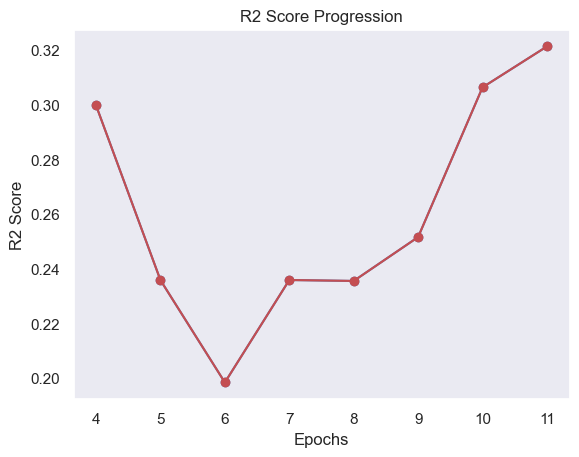

In [290]:
ans = {}
for k, v in r2_list.items():
    if v != None and v > 0 :
        ans[k] = v
        
second_derivatives = []
first_derivatives = []
data = list(ans.values())
for i in range(1, len(data)-1):
    first_derivatives.append(data[i-1] - data[i])
    second_derivative = data[i+1] - 2 * data[i] + data[i-1]
    second_derivatives.append(second_derivative)
inflection_points = [i+1 for i, value in enumerate(second_derivatives) if value > 0 and first_derivatives[i]>0]
inflection_points = [list(ans.keys())[inflection_points[i]] for i in range(len(inflection_points))]

print("Inflection points:", inflection_points)

linear_layers = {}
linear_layers_r2 = {}
n = 12
for k, v in ans.items():
    if v>np.array(list(ans.values())).mean():
        n = k
    if  k >= n or k>inflection_points[0]:# and k not in inflection_points:
        linear_layers[k] = final_coefs[k]
        linear_layers_r2[k] = v

# Create x-axis values (e.g., epochs, iterations, etc.)
x_values = list(ans.keys())
y_values = list(ans.values())
x_values1 = list(linear_layers_r2.keys())
y_values1 = list(linear_layers_r2.values())
# Plot the line graphic
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
plt.plot(x_values1, y_values1, marker='o', linestyle='-', color='r')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.title('R2 Score Progression')
plt.grid()
plt.show()
# linear_layers

### Evaluate Results

In [291]:
tqdm_pbar = lambda x, y: tqdm(x, leave=True, position=0, total=len(x), desc=f'{y}')
def get_cls_embeddings_for_dataset(dataset_name, dataset, 
                                   feature_names, model, tokenizer, 
                                   pbar_func=tqdm_pbar, device=device, CUT_SIZE=CUT_SIZE):
    collected_embeddings = defaultdict(list)

    for split, data in dataset.items():
        
        pbar = pbar_func(data, f"{split} {dataset_name}") if pbar_func is not None else data
        for example in pbar:
            # Encode the input sentences
            if len(feature_names) == 2:
                encoded_inputs = tokenizer.encode(
                    example[feature_names[0]], 
                    example[feature_names[1]], 
                    truncation=True, 
                    return_tensors='pt'
                )
            else:
                encoded_inputs = tokenizer.encode(*list(map(lambda x: example[x] , feature_names)), 
                                              truncation=True, 
                                              return_tensors='pt')
            
            special_token_positions = (encoded_inputs[0] < 103).nonzero().squeeze()
            encoded_inputs = encoded_inputs.to(device)
            
            # Forward pass through the model
            with torch.no_grad():
                outputs = model(encoded_inputs)

            # Get the embedding of the [CLS] token
            cls_embedding = outputs.last_hidden_state[:, 0, :]

            # Append the [CLS] embedding to the list
            collected_embeddings[split].append(cls_embedding)
         
    return collected_embeddings

def train_linear(X_train, y_train):
    classifier = LogisticRegression(solver='lbfgs', max_iter=3000)
    classifier.fit(X_train, y_train)
    return classifier

def evaluate_classifier(classifier, X, y=None):
    predictions = classifier.predict(X)
    return predictions

def get_metrics_report(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred,  average='weighted')
    print('Weighted F1', f1)
    print('Accuracy', accuracy)
    print('-------------------------------')

glue_classification = {'mrpc': ['sentence1', 'sentence2']} # , 'sst2':  ['sentence']}
superglue_classification = {'wic': ['sentence1', 'sentence2']}
all_classification = {'glue': glue_classification, 'superglue': superglue_classification}


glue_datasets = load_datasets('glue', list(glue_classification), 200)
superglue_datasets = load_datasets('super_glue', list(superglue_classification), 200)

all_datasets = {'glue': glue_datasets, 'superglue': superglue_datasets}

def check_results(custom_model):
    
    bert_model = model = AutoModel.from_pretrained("bert-base-uncased")

    for dn, datasets in all_datasets.items():
        for dataset_name, dataset in datasets.items():
            print(f"{dn.upper()} / {dataset_name}\n")
            print('\nLinear:')
            dataset_embeddings_custom = get_cls_embeddings_for_dataset(
                dataset_name,
                dataset, 
                all_classification[dn][dataset_name], 
                custom_model, 
                tokenizer)
            
            train_dataset_embeddings = torch.cat(dataset_embeddings_custom['train'], dim=0).cpu()
            valid_dataset_embeddings = torch.cat(dataset_embeddings_custom['validation'], dim=0).cpu()
            test_dataset_embeddings = torch.cat(dataset_embeddings_custom['test'], dim=0).cpu()
            
            classif = train_linear(train_dataset_embeddings, [el['label'] for el in dataset['train']])
            valid_preds = evaluate_classifier(classif, valid_dataset_embeddings)
            print('Validation evaluation:\n')
            get_metrics_report([el['label'] for el in dataset['validation']], valid_preds)
            print('Original')
            dataset_embeddings_orig = get_cls_embeddings_for_dataset(
                dataset_name,
                dataset, 
                all_classification[dn][dataset_name], 
                bert_model, 
                tokenizer)
            
            train_dataset_embeddings = torch.cat(dataset_embeddings_orig['train'], dim=0).cpu()
            valid_dataset_embeddings = torch.cat(dataset_embeddings_orig['validation'], dim=0).cpu()
            test_dataset_embeddings = torch.cat(dataset_embeddings_orig['test'], dim=0).cpu()
            
            classif = train_linear(train_dataset_embeddings, [el['label'] for el in dataset['train']])
            valid_preds = evaluate_classifier(classif, valid_dataset_embeddings)
            print('Validation evaluation:\n')
            get_metrics_report([el['label'] for el in dataset['validation']], valid_preds)
            # print(train_dataset_embeddings.shape)

Found cached dataset glue (/Users/sashafedorova/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset super_glue (/Users/sashafedorova/.cache/huggingface/datasets/super_glue/wic/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed)


  0%|          | 0/3 [00:00<?, ?it/s]

In [292]:
custom_model = BertWrapperLin(model, LinearClassifierBertAttention, linear_layers,
                       list(linear_layers.keys())).to(device)

check_results(custom_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


GLUE / mrpc


Linear:


train mrpc:   0%|          | 0/200 [00:00<?, ?it/s]

validation mrpc:   0%|          | 0/200 [00:00<?, ?it/s]

test mrpc:   0%|          | 0/200 [00:00<?, ?it/s]

Validation evaluation:

Weighted F1 0.6909898077125143
Accuracy 0.725
-------------------------------
Original


train mrpc:   0%|          | 0/200 [00:00<?, ?it/s]

validation mrpc:   0%|          | 0/200 [00:00<?, ?it/s]

test mrpc:   0%|          | 0/200 [00:00<?, ?it/s]

Validation evaluation:

Weighted F1 0.6956793959319341
Accuracy 0.735
-------------------------------
SUPERGLUE / wic


Linear:


train wic:   0%|          | 0/200 [00:00<?, ?it/s]

validation wic:   0%|          | 0/200 [00:00<?, ?it/s]

test wic:   0%|          | 0/200 [00:00<?, ?it/s]

Validation evaluation:

Weighted F1 0.48
Accuracy 0.48
-------------------------------
Original


train wic:   0%|          | 0/200 [00:00<?, ?it/s]

validation wic:   0%|          | 0/200 [00:00<?, ?it/s]

test wic:   0%|          | 0/200 [00:00<?, ?it/s]

Validation evaluation:

Weighted F1 0.5980676328502416
Accuracy 0.6
-------------------------------
